<a href="https://colab.research.google.com/github/benbot8/text-summarization/blob/main/automatic_summary_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**bold text**# Scenario:  Summarizing, categorizing & structuring information from a video 

The following is a multi-step process to extract information from a given video. It consists of:

1.   Extract the transcript of the video
2.   Extract information through named entities
3.   Create a summary based on the transcript
4.   Extract textual information of the slides in the video
5. Create a summary based on the detected text on the slides

The input is now a video but later be any textual information. See also "Future steps" below. 

The reference data is a [presentation from Prof. Nigel Scrutton.](https://ukcatalysishub.co.uk/microbial-cell-factories-engineering-biology-for-chemicals-production/)

The following is a detailed summary: 

1. Install required packages
2. Connection to AWS resrouces
3. Load Reference Data 
4. Extract Raw Text from the input video 
5. Preprocess the text data 
6. Extract information
   - Named Entities using NLTK
   - Named Entities using Comprehend
7. Create an automatic summary
   - Summary using NLTK
   - Summary using BERT
   - Summary using Pegasus
8. Extract information from slides in the lecture video
9. Create a summary based on the slides 

Especially in step 8, state-of-the-art text summarization algorithms are being applied. Text summarization refers to extracting (summarizing) out the relevant information from a large document while retaining the most important information. 
Two different approaches are being introduced: 
  * an extraction-based approach using BERT: Bidirectional Encoder Representations from Transformers (BERT) is a Transformer-based machine learning technique for natural language processing (NLP) pre-training developed by Google. As of 2019, Google has been leveraging BERT to better understand user searches. 
  * an abstraction-based approach using PEGASUS: Pre-training with Extracted Gap-sentences for Abstractive Summarization (PEGASUS) is a new approach that has recently become favored as it is more effective at modeling the dependencies present in the long sequences encountered in summarization.

Both models are pre-trained on huge datasets thus no further training is required (transfer learning).

Future steps: 

*   Build pipeline to handle multiple types of input: 
  * Speech-to-Text (Videos, Audio)
  * Textual documents 
*   Export model as API 





## 1. Install the required dependencies

In [ ]:
# TODO: put all those dependencies into a requirements.txt once complete
!pip install youtube_transcript_api
!pip install spacy
!pip install wordcloud
#!git clone https://github.com/huggingface/transformers
#!pip install transformers/.
#!pip install Sentencepiece
#!pip install --upgrade tensorflow
!pip install nltk
!pip install rouge
#!pip install pytesseract

^C
Cloning into 'transformers'...
remote: Enumerating objects: 316, done.
remote: Counting objects: 100% (316/316), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 69120 (delta 175), reused 243 (delta 125), pack-reused 68804
Receiving objects: 100% (69120/69120), 52.65 MiB | 30.48 MiB/s, done.
Resolving deltas: 100% (48889/48889), done.
Processing ./transformers
  Installing build dependencies ... canceled
ERROR: Operation cancelled by user
^C
     |████████████████████████████████| 1.2MB 17.8MB/s 
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.7/dist-packages (2.4.1)
  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13945 sha256=e63e1443ebb878d49fb30d71ac79016fe35791e45eaf03665af3124191c54775
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract


In [ ]:
#Install required and/or update third-party libraries
!python -m pip install -Uq pip
!python -m pip install -q awswrangler==2.2.0 imbalanced-learn==0.7.0 sagemaker==2.23.1 

     |████████████████████████████████| 1.5MB 4.0MB/s 
     |████████████████████████████████| 151 kB 4.3 MB/s 
     |████████████████████████████████| 167 kB 28.2 MB/s 
     |████████████████████████████████| 400 kB 42.1 MB/s 
     |████████████████████████████████| 47 kB 4.0 MB/s 
     |████████████████████████████████| 7.3 MB 48.7 MB/s 
     |████████████████████████████████| 17.7 MB 85 kB/s 
     |████████████████████████████████| 131 kB 40.4 MB/s 
     |████████████████████████████████| 81 kB 9.0 MB/s 
     |████████████████████████████████| 22.3 MB 49.7 MB/s 
     |████████████████████████████████| 69 kB 7.2 MB/s 
     |████████████████████████████████| 153 kB 51.2 MB/s 
     |████████████████████████████████| 5.5 MB 40.4 MB/s 
     |████████████████████████████████| 94 kB 2.5 MB/s 
     |████████████████████████████████| 510 kB 43.7 MB/s 
     |████████████████████████████████| 127 kB 53.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packag

In [ ]:
#### Import all relevant stuff
from youtube_transcript_api import YouTubeTranscriptApi
import json
import spacy
import re
import nltk
import heapq
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
#import boto3
import string
#import sagemaker
#import awswrangler as wr
import nltk
#import cv2
import logging
import os
import random
import string
#import pytesseract

from rouge import Rouge  
#from sagemaker.feature_store.feature_group import FeatureGroup

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
rouge = Rouge()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## 2. Connection to AWS Resources 

In [ ]:
# attach feature store access role to current SageMaker role to use AWS resources such as S3 
print('SageMaker Role:', sagemaker.get_execution_role().split('/')[-1])

## Set region, boto3 and SageMaker SDK variables

In [ ]:
region = sagemaker.Session().boto_region_name
print("Using AWS Region: {}".format(region))

In [ ]:
boto3.setup_default_session(region_name=region)

boto_session = boto3.Session(region_name=region)

s3_client = boto3.client('s3', region_name=region)

sagemaker_boto_client = boto_session.client('sagemaker')

sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_boto_client)

In [ ]:
"""
Note: if you are not running this notebook from SageMaker Studio or SageMaker Classic Notebooks you will need to instanatiate 
the sagemaker_execution_role_name with an AWS role that has SageMakerFullAccess and SageMakerFeatureStoreFullAccess
"""
sagemaker_execution_role_name = 'AmazonSageMaker-ExecutionRole-20210107T234882'
try:
    sagemaker_role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    sagemaker_role = iam.get_role(RoleName=sagemaker_execution_role_name)['Role']['Arn']
    print(f"\n instantiating sagemaker_role with supplied role name : {sagemaker_role}")

account_id = boto3.client('sts').get_caller_identity()["Account"]

## Create a directory in the SageMaker default bucket for this tutorial

In [ ]:
if 'bucket' not in locals():
    bucket = sagemaker_session.default_bucket()
    prefix = 'ci-data-nlp-scenario-3'
    %store bucket
    %store prefix
    print(f'Creating bucket: {bucket}...')

# 3. Load Reference Data  


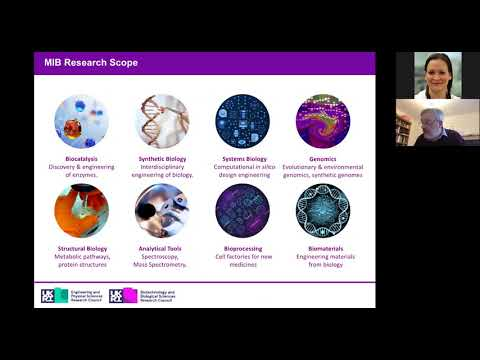

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('ZMpCPlm-Stk')

## 4. Extract Raw Text from the input video 

In [ ]:
video_id = 'ZMpCPlm-Stk'
transcript_js = YouTubeTranscriptApi.get_transcript(video_id)
transcript_js

# 5. Preprocess the text data

In [ ]:
transcript = open('./scenario3_transcript_processed.txt', 'r')
transcript = transcript.read()

In [ ]:
transcript

"welcome everyone to the October installment of the task of Webinar series. Um, it's my very great pleasure to introduce fresh Nigel Stratton from the Manchester Institute of Biotechnology in Manchester University, who will be talking about microbial cell factor factories. Sorry, I've lost my ability to read, um, an engineering biology for chemical production. Um, I will hand straight over tonight, all but if you could use the Q and A function to ask questions and we will answer all the questions at the end. Do you have any technical difficulties or any issues or would like to introduce yourself and let us know where you're from? Please use the chat button. Um, on on that, I will hand straight over to Professor Scrutton. Okay, Thank you very much. Thanks. Very, very kind introduction. It's a pleasure to be with you all this afternoon and for me to be able to tell you about our recent work on engineering biology for chemicals production and by manufacturing. So what I'd like to do today

In [ ]:
# extract text from the json format
#transcript = ' '.join([item.get('text') for item in transcript_js])
import re

# Removing Square Brackets and Extra Spaces
#transcript = re.sub(r'%', ' PERCENT ', transcript)
transcript = re.sub(r'\[[0-9]*\]', ' ', transcript)
transcript = re.sub(r'\s+', ' ', transcript)
#remove uhs
transcript = re.sub(r'\s+uh\s*,\s+|\s+uh\s+|\s+um,|^um\s+|\s+um\s+', '', transcript,  flags=re.IGNORECASE)
#transcript = re.sub(r' PERCENT ', '% ', transcript,  flags=re.IGNORECASE)

# Removing special characters and digits
#transcript = re.sub('[^a-zA-Z]', ' ', transcript )
#transcript = re.sub(r'\s+', ' ', transcript)
#punkt = nltk.tokenize.punkt.PunktSentenceTokenizer()
# punkt.sentences_from_text(transcript)

#nltk.download('punkt')
#f = open("./punktuated_transcript.txt", "r")
#punkt_transcript = f.read()
#f.close()
#punkt_transcript = re.sub(r'\s+uh\s*,\s+|\s+uh\s+|\s+um,|^um\s+|\s+um\s+', '', punkt_transcript,  flags=re.IGNORECASE)
#sentences = nltk.sent_tokenize(punkt_transcript)
#sentences

In [ ]:
transcript

"welcome everyone to the October installment of the task of Webinar series. it's my very great pleasure to introduce fresh Nigel Stratton from the Manchester Institute of Biotechnology in Manchester University, who will be talking about microbial cell factor factories. Sorry, I've lost my ability to read, an engineering biology for chemical production. I will hand straight over tonight, all but if you could use the Q and A function to ask questions and we will answer all the questions at the end. Do you have any technical difficulties or any issues or would like to introduce yourself and let us know where you're from? Please use the chat button. on on that, I will hand straight over to Professor Scrutton. Okay, Thank you very much. Thanks. Very, very kind introduction. It's a pleasure to be with you all this afternoon and for me to be able to tell you about our recent work on engineering biology for chemicals production and by manufacturing. So what I'd like to do today is to discuss o

In [ ]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

#get completely rid of stopwords
stop_words = set(stopwords.words('english')) 
file1 = open("scenario3_transcript_processed.txt")  
transcript = file1.read()
transcript = re.sub(r'\[[0-9]*\]', ' ', transcript)
transcript = re.sub(r'\s+', ' ', transcript)
#remove uhs
transcript = re.sub(r'\s+uh\s*,\s+|\s+uh\s+|\s+um,|^um\s+|\s+um\s+', '', transcript,  flags=re.IGNORECASE)
# Use this to read file content as a stream: 
words = transcript.split() 
for r in words: 
    if not r in stop_words: 
        appendFile = open('filteredtext.txt','a') 
        appendFile.write(" "+r) 
        appendFile.close() 

In [ ]:
transcript = open("filteredtext.txt")
transcript = transcript.read()

In [ ]:
transcript

" welcome everyone October installment task Webinar series. great pleasure introduce fresh Nigel Stratton Manchester Institute Biotechnology Manchester University, talking microbial cell factor factories. Sorry, I've lost ability read, engineering biology chemical production. I hand straight tonight, could use Q A function ask questions answer questions end. Do technical difficulties issues would like introduce let us know from? Please use chat button. that, I hand straight Professor Scrutton. Okay, Thank much. Thanks. Very, kind introduction. It's pleasure afternoon able tell recent work engineering biology chemicals production manufacturing. So I'd like today discuss work establish establishing automated foundry microbial strain engineering impact chemicals fuels production, work translated scale commercial production selected advanced fuels. Mhm. So we're provide context, course, manufacturing significant contributor UK economy we're cusp. I think rapid expansion sector urgently try

In [ ]:
doc = transcript

# 6. Extract information (named entities)

In [ ]:
!python3 -m spacy download en_core_web_lg
!python3 -m spacy download en_core_web_sm

     |████████████████████████████████| 827.9MB 1.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp37-none-any.whl size=829180944 sha256=fd0eeeb4442cfeb2ed61b7f4347561179713f85897b3769bc9855836e34b35c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-8le5lr07/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
# Creating a spaCy object
nlp = spacy.load('en_core_web_sm')

#Vectorizing the text 
doc = nlp(doc)
spacy.displacy.render(doc, style='ent',jupyter=True)

In [ ]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(transcript)
spacy.displacy.render(doc, style='ent',jupyter=True)

In [ ]:
def entity_freqs(entities):
    """Build frequencies.
    Input:
       list of entities
    Output:
        freqs: a dictionary mapping each (entity, type) pair to its
        frequency
    """
    freqs = {}
    for ent in entities:
            pair = (ent.text, ent.label_)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1
    return freqs

entis = entity_freqs(doc.ents)
entis= [[k[0],k[1],r] for k,r in entis.items()]

ent_df = pd.DataFrame(entis,columns=["Entity","type","Frequency"])
ent_df

,Entity,type,Frequency
0,October,DATE,1
1,Nigel Stratton Manchester Institute Biotechnol...,ORG,1
2,tonight,TIME,1
3,Scrutton,PERSON,1
4,afternoon,TIME,2
...,...,...,...
197,liquefaction.it,PERSON,1
198,Acrylic,ORG,1
199,P. R. H.,PERSON,1
200,next month,DATE,1


In [ ]:
ent_df[(ent_df.type=='PERSON')]

,Entity,type,Frequency
3,Scrutton,PERSON,1
15,U. K,PERSON,1
18,Glasgow 2021,PERSON,1
19,Manchester,PERSON,2
22,Queen,PERSON,1
...,...,...,...
194,Gavin,PERSON,1
195,Minas,PERSON,1
197,liquefaction.it,PERSON,1
199,P. R. H.,PERSON,1


In [ ]:
# store csv file in S3 
file_name = "named_entities.csv"
ent_df.to_csv(file_name)
#s3_client.upload_file(Filename='./processed/named_entities.csv', Bucket=bucket, Key=f'{prefix}/data/processed/named_entities.csv')

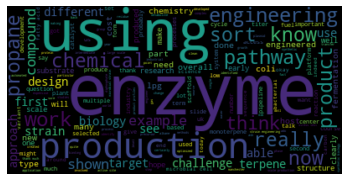

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(transcript)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# 7. Text summarization  




### 1. Load Text

In [ ]:
with open('punktuated_transcript.txt','r') as f:
    body = f.read()

body

"Um welcome everyone to the october installment of the task hub webinar series um, it's my very great pleasure to introduce fresh and nigel stratton from the manchester institute of biotechnology in manchester university um, who will be talking about microbial cell factor factories. Sorry, i've lost my ability to read an engineering biology for chemical production. I will hand straight over to nigel, but if you could use the q a function to ask questions and we will answer all the questions at the end, if you have any technical difficulties or any issues or would like to introduce yourself and let us know where You'Re from please use the chat button and, on that i'll hand straight over to professor scrotum, okay. Thank you very much. Thanks for a very kind introduction, uh, it's a pleasure to be with you all this afternoon and for me to be able to tell you about our recent work on engineering biology for chemicals, production and biomanufacturing. So what i'd like to do today is to dis

In [ ]:
import re
# Removing Square Brackets and Extra Spaces
body = re.sub(r'\[[0-9]*\]', ' ', body)
body = re.sub(r'\s+', ' ', body)
#remove uhs
body = re.sub(r'\s+uh\s*,\s+|\s+uh\s+|\s+um,|^um\s+|\s+um\s+', '', body,  flags=re.IGNORECASE)

In [ ]:
body

"welcome everyone to the october installment of the task hub webinar series it's my very great pleasure to introduce fresh and nigel stratton from the manchester institute of biotechnology in manchester university who will be talking about microbial cell factor factories. Sorry, i've lost my ability to read an engineering biology for chemical production. I will hand straight over to nigel, but if you could use the q a function to ask questions and we will answer all the questions at the end, if you have any technical difficulties or any issues or would like to introduce yourself and let us know where You'Re from please use the chat button and, on that i'll hand straight over to professor scrotum, okay. Thank you very much. Thanks for a very kind introduction,it's a pleasure to be with you all this afternoon and for me to be able to tell you about our recent work on engineering biology for chemicals, production and biomanufacturing. So what i'd like to do today is to discuss our work on

## 2. Prepare tokenizer and load pre-trained model

### a. Extractive approach using BERT:

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# prepare BART Tokenizer, which inherits from ~transformers.PreTrainedTokenizer
bart_tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-cnn-12-6")
# load pre-trained model 
bart_model = AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-cnn-12-6")

type(bart_tokenizer)

RuntimeError: ignored

### b. Abstractive approach using PEGASUS:

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

pegasus_tokenizer = AutoTokenizer.from_pretrained("google/pegasus-cnn_dailymail")

pegasus_model = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-cnn_dailymail")

type(pegasus_tokenizer)

transformers.models.pegasus.tokenization_pegasus_fast.PegasusTokenizerFast

## 3. If needed: split the input text into multiple smaller texts to avoid runtime error


In [ ]:
# generate chunks of text \ sentences <= max length of the model (usually 1024 tokens)
def nest_sentences(document):
  nested = []
  sent = []
  length = 0
  for sentence in nltk.sent_tokenize(document):
    length += len(sentence)
    if length < len(document)/8: #tokenizer.model_max_length:
      sent.append(sentence)
    else:
      nested.append(sent)
      sent = []
      length = 0

  if sent:
    nested.append(sent)
  return nested

## 4. Apply the model to the given input

### a. BERT 

In [ ]:
# chunk the input 
chunked = nest_sentences(body)

In [ ]:
# generate summary on text with <= max length of the model (usually 1024 tokens)
def generate_summary(nested_sentences):
  summaries = []
  for nested in nested_sentences:
    input_tokenized = bart_tokenizer.encode(' '.join(nested), truncation=True, return_tensors='pt')
    input_tokenized = input_tokenized
    summary_ids = bart_model.generate(input_tokenized,
                                      length_penalty=3.0,
                                      min_length=30,
                                      max_length=100)
    output = [bart_tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
    summaries.append(output)
  summaries = [sentence for sublist in summaries for sentence in sublist]
  return summaries

In [ ]:
summary = generate_summary(chunked)

In [ ]:
summary # chunked summary

["Professor scrotum will talk about setting up an automated biofoundry for microbial strain engineering .<n>Some of this work is now being translated to scale for the Commercial production of selected, advanced fuels .<n>Professor scrotum will also talk about how some of this work is now being translated to scale for the Commercial production of selected, advanced fuels .<n>We need to change and transition to a more sustainable biomanufacturing sector as part of the UK's economic recovery .",
 'We identified 25 targets encompassing seven compound classes .<n>These includevinyl, benzenes, alloy, benzenes, mandalas, isobutyl compounds, diols, dienes and carboxylates .<n>We then set ourselves a notional 90-day limit to walk through the design, build test and learn cycle .<n>Overall, we estimate that the personnel and consumable costs amounted to around fifteen thousand pounds per successful target, corresponding to 360 personnel hours per compound ',
 'We can identify three subgroups, the

In [ ]:
cleaned = []
for s in summary:
  s = s.replace('<n>'," ")
  cleaned.append(s)

In [ ]:
cleaned

["Professor scrotum will talk about setting up an automated biofoundry for microbial strain engineering . Some of this work is now being translated to scale for the Commercial production of selected, advanced fuels . Professor scrotum will also talk about how some of this work is now being translated to scale for the Commercial production of selected, advanced fuels . We need to change and transition to a more sustainable biomanufacturing sector as part of the UK's economic recovery .",
 'We identified 25 targets encompassing seven compound classes . These includevinyl, benzenes, alloy, benzenes, mandalas, isobutyl compounds, diols, dienes and carboxylates . We then set ourselves a notional 90-day limit to walk through the design, build test and learn cycle . Overall, we estimate that the personnel and consumable costs amounted to around fifteen thousand pounds per successful target, corresponding to 360 personnel hours per compound ',
 'We can identify three subgroups, the bicyclic mo

In [ ]:
df = pd.DataFrame(data={"chunked_summaries": cleaned})
df.to_csv("./chunked_summaries.csv", sep=',',index=False)

### b. PEGASUS

In [ ]:
# apply tokenizer and create summarization 
batch = pegasus_tokenizer(transcript, truncation=True, padding='longest', return_tensors="pt")
translated = pegasus_model.generate(**batch)
tgt_text = pegasus_tokenizer.batch_decode(translated, skip_special_tokens=True)
final_summary = tgt_text[0]

In [ ]:
final_summary

'Nigel Stratton from the Manchester Institute of Biotechnology will be talking about microbial cell factor factories.<n>He will talk about establishing an automated by a foundry for microbial strain engineering.<n>And how some of this work is now being translated to scale for the commercial production of selected advanced fuels.'

In [ ]:
cleaned = final_summary.replace('<n>'," ")

In [ ]:
cleaned

'Nigel Stratton from the Manchester Institute of Biotechnology will be talking about microbial cell factor factories. He will talk about establishing an automated by a foundry for microbial strain engineering. And how some of this work is now being translated to scale for the commercial production of selected advanced fuels.'

In [ ]:
cleaned = "Professor scrotum from the manchester institute of biotechnology in manchester will be talking about microbial cell factor factories. Professor scrotum will discuss the work on establish, establishing an automated biofoundry for microbial strain engineering. Some of this work is now being translated to scale for the Commercial production of selected, advanced fuels."

In [ ]:
f = open("summary.txt", "a")
f.write(cleaned)
f.close()

## Additional work and clean-up

In [ ]:
scores = rouge.get_scores(summary, body)
print(scores)

[{'rouge-1': {'f': 0.038364462016445486, 'p': 1.0, 'r': 0.0195573854863613}, 'rouge-2': {'f': 0.037392622169699484, 'p': 1.0, 'r': 0.01905252317198764}, 'rouge-l': {'f': 0.11666666556805556, 'p': 1.0, 'r': 0.061946902654867256}}]


# 8. Extract information from slides 

In [ ]:
def rand_string(length):
    """ Generates a random string of numbers, lower-and upper chars."""
    rand_str =''.join(random.choice(
        string.ascii_lowercase
        +string.ascii_upperrcase
        +string.digits)
                     for i in range(length))
    return rand_str
def extract_text(image):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    text = pytesseract.image_to_string(img_rgb)
    if text is not None:
        if len(text.strip())== 0:
            return None
    return text
    
    
def crop_image(image):
    """y=0
    x=44
    h=348
    w=456
    """
    y=0
    x=90
    h=680
    w=910
    crop = image[y:y+h, x:x+w]
    return crop

#Generate a random string of numbers to use as a part of our output file names
def rand_string(length):
    """ Generates a random string of numbers, lower-and upper chars."""
    rand_str = ''.join(random.choice(
        string.ascii_lowercase
        + string.ascii_uppercase
        +string.digits)
        for i in range(length))
    return rand_str

#calculating the length of the video / frame count
def length_of_video(video_path):
    cap = cv2.VideoCapture(video_path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))    #frame count
    #print(length)
    return length

#extraction of video to images
def extracting_frames(video_path, save_path, till = 50):
    print('Extracting frames')
        #param 1: path of the source (video)
        #param 2: where the output images saved
        #param 3: when the extraction should stop 

    #split the path to directory and the file name itself
    _, file_name = os.path.split(video_path)
    #getting the file_name without the extention
    file_name = os.path.splitext(file_name)[0]

    length = length_of_video(video_path)
    if length == 0:
        print('Video length is zero')
        return 0

    cap = cv2.VideoCapture(video_path)
    count = 0           #counting frames
    random_string = rand_string(5)              #for naming each frame

    #check if it is working by checking the very first frame of the video
    ret, frame = cap.read()
    test_file_path = os.path.join(
        save_path,
        file_name[:6] +\
        '{}_{}.jpg'.format(random_string, count))

    cv2.imwrite(test_file_path, frame)
    if os.path.isfile(test_file_path):
        print('Test frame saved,' + 'Continuing Extraction')

        #continuing the extraction 
        count = 1
        prev_frame = None
        while ret:
            ret, frame = cap.read()
            crop = crop_image(frame)
            #if frame is available and count is less than till, continue extraction
            if ret: #and count < till:
                if prev_frame is not None:
                    difference = cv2.subtract(crop, prev_frame)
                    #print('Difference {a}'.format( a=difference.sum()))
                if prev_frame is None or difference.sum() >5014766:
                    img_text = extract_text(crop)
                    #img_text=1
                    if img_text is not None:
                        print(img_text)
                        prev_frame = crop
                        file_path = os.path.join(
                            save_path,
                            file_name[:6]+
                            '{}_{}.jpg'.format(random_string, count))
                        #crop = crop_image(frame)
                        cv2.imwrite(file_path, crop)
                        #cv2.imwrite(file_path, frame)
                        count +=1
                    #print(count)
                    
            else:
                count +=1
    else:
        print('Problem with saving the file!')
        return 0
    cap.release()
    print('Extraction completed!')

In [ ]:
video_frame = ["./input/microbial_cell_factoriesHD.mp4"]
save_path = "./output/video_frames"
save_path = "./output/frames"
for video in video_frame:
    print(video)
    extracting_frames(video, save_path, till=100)

In [ ]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in glob.glob('./output/selection/*.jpg'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(455,340))
columns = 2
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

In [ ]:
directory_str="./output/frames/"
write_data(directory_str, dest_file_str,header)

In [ ]:
def write_data(directory_str, dest_file_str, header):
    directory = os.fsencode(directory_str)
    dest_file = open(dest_file_str, "w")
    dest_file.write(header + "\n")
    for file_b in os.listdir(directory):
        filename = os.fsdecode(file_b) 
        if filename.endswith(".jpg") or filename.endswith(".png"): 
           
            image= cv2.imread("{}{}".format(directory_str,filename))
            img_text = extract_text(image)
            #print(img_text)
            img_text = re.sub(r'\[[0-9]*\]', ' ', img_text)
            img_text = re.sub(r'\s+', ' ', img_text)
            img_text = re.sub(r'\n+', '. ', img_text)
            print(img_text)
            stri= "{text};\n".format(slide=filename,text=img_text )
            
            dest_file.write(stri + "\n")
    dest_file.close()

In [ ]:
directory_str="./output/frames/"
#dest_file_str = "./output/frames/slides_extract.csv"
dest_file_str = "./output/frames/slides_extract.txt"
header="Slide;Text;"
write_data(directory_str, dest_file_str,header)

In [ ]:
import re
# Removing Square Brackets and Extra Spaces
slides_text = re.sub(r'\[[0-9]*\]', ' ', slides_text)
slides_text = re.sub(r'\s+', ' ', slides_text)
#remove uhs
slides_text = re.sub(r'\s+uh\s*,\s+|\s+uh\s+|\s+um,|^um\s+|\s+um\s+', '', slides_text,  flags=re.IGNORECASE)

In [ ]:
f = open("./rawText.txt", "r")
slides_text = f.read()
f.close()


In [ ]:
slides_text

' Microbial Cell Factories for Chemicals Production Microbial Cell Factories - Engineering Biology for Chemicals Production Future SYNBIOCHEM Biomanufacturing C3 BIOTECH Research Hub Marichester Syntheric Biology Research Centre for Fine and Speciolity Chemicos FBRH ENERGISING A LOW CARBON WORLD Scrutton Lab Manchester Institute of Biotechnology & Department of Chemistry The University of Manchester The UK Biomanufacturing Economy Biomanufacturing: unlocking \'clean growth\' to (Build Back Better\' Major contributor to the UK economy £3.7bn in revenue; £1.2 bn in GVA - The chemicals industry is vital to the UK economy: 3,608 businesses employing 153,000 people, giving £19.2bn gross value added on a turnover of £55.5bn. - Majority of production from non-renewable petrochemicals. - At odds with Paris Agreement obligations to reduce greenhouse gas emissions by 80 per cent by 2050. - We need to change. Scrutton & Malone, Biomanufacturing: a path to sustainable economic recovery. New States

In [ ]:
# summary of detected text on slides
batch = pegasus_tokenizer(slides_text, truncation=True, padding='longest', return_tensors="pt")
translated = pegasus_model.generate(**batch)
tgt_text = pegasus_tokenizer.batch_decode(translated, skip_special_tokens=True)
final_summary = tgt_text[0]

In [ ]:
final_summary

'Major contributor to the UK economy £3.7bn in revenue; £1.2 bn in GVA.<n>Majority of production from non-renewable petrochemicals.<n>Paris Agreement obligations to reduce greenhouse gas emissions by 80 per cent by 2050.'

In [ ]:
f = open("./slides_extract.txt", "r")
slides_text = f.read()
f.close()

sentences = nltk.sent_tokenize(slides_text)
sentences

nlp = spacy.load("en_core_web_sm")
doc = nlp(slides_text)
spacy.displacy.render(doc, style='ent',jupyter=True)

In [ ]:
entis = entity_freqs(doc.ents)
entis= [[k[0],k[1],r] for k,r in entis.items()]

ent_df = pd.DataFrame(entis,columns=["Entity","type","Frequency"])
ent_df

,Entity,type,Frequency
0,BiomanufacturingEcon,ORG,1
1,UK,GPE,33
2,3,CARDINAL,6
3,the Industrial Strategy Growing the sail,ORG,1
4,Bioeconomy,PERSON,1
...,...,...,...
383,Sakuma,GPE,1
384,Shaowei Zhang TobiasHedison,PERSON,1
385,Matthew Faulkner,PERSON,1
386,C3 Biotech ltd,ORG,1


In [ ]:
file_name = "named_entities_slides.csv"
ent_df.to_csv(file_name)

In [ ]:
from spacy.matcher import PhraseMatcher


nlp = spacy.load("en_core_web_sm")

phrase_matcher = PhraseMatcher(nlp.vocab)
phrases = ['Neuroscience', 'Biology']
patterns = [nlp(slides_text) for text in phrases]
phrase_matcher.add('Biology', None, *patterns)

doc = nlp(slides_text)

for sent in doc.sents:
    for match_id, start, end in phrase_matcher(nlp(sent.text)):
        if nlp.vocab.strings[match_id] in ["AI"]:
            print(sent.slides_text)

In [ ]:
# some python file
#import textract
#text = textract.process('./input/images/image20.png')
import pytesseract
img_cv = cv2.imread(r'./input/images/image30.jpeg')

# By default OpenCV stores images in BGR format and since pytesseract assumes RGB format,
# we need to convert from BGR to RGB format/mode:
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

# OR
text = pytesseract.image_to_string(img_rgb)
print(text)
print(len(text.strip()))
if text is None:
    print('None')

In [ ]:
import pytesseract
def extract_text(image):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    text = pytesseract.image_to_string(img_rgb)
    return text


img_cv = cv2.imread(r'./input/images/image30.jpeg')
mytext =  extract_text(img_cv)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
im = cv.imread(r'./output/frames/microbRNFW9_19.jpg')
imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

plt.imshow(im)
plt.title('original')
plt.show()

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
#im an H X W array.
im = cv.imread(r'./output/frames/microbRNFW9_19.jpg')
im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
contours, hierarchy = cv.findContours(im, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
im = np.expand_dims(im, axis=2).repeat(3, axis=2) 
for k, _ in enumerate(contours):
    im = cv.drawContours(im, contours, k, (0, 230,1000), 10)
plt.imshow(im)

# 9. Summary based on slides